In [1]:
import itertools
import multiprocessing as mp
import os
import shutil
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import f_classif, SelectKBest
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelBinarizer

from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

In [2]:
# supress tensorflow warnings and info
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [3]:
# load csv as dataframe
df_csv = pd.read_csv('banco.csv', sep='§')
df_csv

/tmp/ipykernel_81574/2250565721.py:2: ParserWarning: Falling back to the 'python' engine because the separator encoded in utf-8 is > 1 char long, and the 'c' engine does not support such separators; you can avoid this warning by specifying engine='python'.
  df_csv = pd.read_csv('banco.csv', sep='§')


,Questionnaire Name,Account Number,ID COUNT,0_Number_of_inst,Population,Tag_unique_city,Country,CDP Region,Response Language,Privacy,Project title,Translated project title,Project description and attach project proposal,Translated project description,Project area,Simple Project Area,sub_categoria
0,Cities 2022,31155,"0,125",1,3078836,0.0,Argentina,Latin America,Spanish,Public,Diseño sustentable de vivienda social,Sustainable design of social housing,Diseñar y construir un prototipo de vivienda s...,Design and build a prototype of social housing...,Energy efficiency (including public lighting),Energy Efficiency,NaN
1,Cities 2022,31155,"0,125",1,3078836,0.0,Argentina,Latin America,Spanish,Public,Fomento de instalaciones solares fotovoltaicas...,Promotion of photovoltaic solar installations ...,Desarrollar una plataforma de vinculación y as...,Develop a platform for linking and associating...,Renewable energy,Renewable energy,NaN
2,Cities 2022,31155,"0,125",1,3078836,0.0,Argentina,Latin America,Spanish,Public,Fortalecimiento de CIFA (Centro de Información...,Strengthening CIFA (Environmental Information ...,Se busca posicionar al Centro de Información y...,It seeks to position the Center for Environmen...,Renewable energy,Renewable energy,NaN
3,Cities 2022,31155,"0,125",1,3078836,0.0,Argentina,Latin America,Spanish,Public,Generación Solar Comunitaria con impacto socia...,Community Solar Generation with Broad Social I...,Estudio técnico-económico para la implementaci...,Technical-economic study for the implementatio...,Renewable energy,Renewable energy,NaN
4,Cities 2022,31155,"0,125",1,3078836,0.0,Argentina,Latin America,Spanish,Public,Mapa Solar de la Ciudad,Solar Map of the City,Desarrollar herramienta para proveer de inform...,Develop a tool to provide information to citiz...,Renewable energy,Renewable energy,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
473,Cities 2022,839673,"0,333333333333333",1,75359,1.0,Peru,Latin America,English,Public,Jesus Maria Wastewater Treatment Plant,Jesus Maria Wastewater Treatment Plant,The Treatment Plant for the Irrigation Waters ...,The Treatment Plant for the Irrigation Waters ...,Water management,Water management,NaN
474,Cities 2022,839672,1,1,140679,1.0,Peru,Latin America,Spanish,Public,Mejoramiento de la infraestructura del Parque...,Improvement of the infrastructure of the Ecolo...,EL proyecto de inversión pública denominado “M...,"THE public investment project called ""IMPROVEM...",Public and green spaces,Public and green spaces,NaN
475,Cities 2022,60388,1,1,270496,1.0,Peru,Latin America,Spanish,Public,NaN,NaN,ASUME GIZ,NaN,"Other, please specify: ALERTA CIUDADANA",Other,NaN
476,Cities 2022,42388,1,1,1319108,1.0,Uruguay,Latin America,Spanish,Public,Transformación Integral de la cuenca del Arroy...,Integral Transformation of the Arroyo Pantanos...,En curso consultoría para proyectos de interve...,Ongoing consultancy for intervention projects ...,Water management,Water management,NaN


In [4]:
# start cleaning the dataframe
df_filtered = df_csv.rename(columns={'Translated project title': 'title',
                                     'Translated project description': 'desc',
                                     'Simple Project Area': 'area'})
df_filtered = df_filtered[['title', 'desc', 'area']]
df_filtered = df_filtered[df_filtered.notna().all(axis='columns')].reset_index(drop=True)
df_filtered

,title,desc,area
0,Sustainable design of social housing,Design and build a prototype of social housing...,Energy Efficiency
1,Promotion of photovoltaic solar installations ...,Develop a platform for linking and associating...,Renewable energy
2,Strengthening CIFA (Environmental Information ...,It seeks to position the Center for Environmen...,Renewable energy
3,Community Solar Generation with Broad Social I...,Technical-economic study for the implementatio...,Renewable energy
4,Solar Map of the City,Develop a tool to provide information to citiz...,Renewable energy
...,...,...,...
362,Cycle Path in Jesus Mary,For the improvement of the district's cycle sy...,Transport
363,Jesus Maria Wastewater Treatment Plant,The Treatment Plant for the Irrigation Waters ...,Water management
364,Improvement of the infrastructure of the Ecolo...,"THE public investment project called ""IMPROVEM...",Public and green spaces
365,Integral Transformation of the Arroyo Pantanos...,Ongoing consultancy for intervention projects ...,Water management


In [5]:
# convert text to lowercase
df_lower = df_filtered.copy()
df_lower['title'] = df_lower['title'].str.lower()
df_lower['desc'] = df_lower['desc'].str.lower()
df_lower['area'] = df_lower['area'].str.lower()
df_lower

,title,desc,area
0,sustainable design of social housing,design and build a prototype of social housing...,energy efficiency
1,promotion of photovoltaic solar installations ...,develop a platform for linking and associating...,renewable energy
2,strengthening cifa (environmental information ...,it seeks to position the center for environmen...,renewable energy
3,community solar generation with broad social i...,technical-economic study for the implementatio...,renewable energy
4,solar map of the city,develop a tool to provide information to citiz...,renewable energy
...,...,...,...
362,cycle path in jesus mary,for the improvement of the district's cycle sy...,transport
363,jesus maria wastewater treatment plant,the treatment plant for the irrigation waters ...,water management
364,improvement of the infrastructure of the ecolo...,"the public investment project called ""improvem...",public and green spaces
365,integral transformation of the arroyo pantanos...,ongoing consultancy for intervention projects ...,water management


In [6]:
# list all categories (the output) and their counts
area_count = pd.DataFrame(df_lower.value_counts(subset='area'))
area_count

,0
area,
waste management,66
water management,56
transport,53
other,37
renewable energy,27
public and green spaces,27
energy efficiency,25
monitoring,12
nature-based solutions,12


In [7]:
# remove categories with few samples
min_sample_count = 20
area_count = area_count.rename({0: 'count'}, axis='columns')
areas_to_keep = area_count[area_count > min_sample_count].dropna().index.to_list()
area_filter = df_lower['area'].isin(areas_to_keep)
df_clean = df_lower[area_filter]
df_clean

,title,desc,area
0,sustainable design of social housing,design and build a prototype of social housing...,energy efficiency
1,promotion of photovoltaic solar installations ...,develop a platform for linking and associating...,renewable energy
2,strengthening cifa (environmental information ...,it seeks to position the center for environmen...,renewable energy
3,community solar generation with broad social i...,technical-economic study for the implementatio...,renewable energy
4,solar map of the city,develop a tool to provide information to citiz...,renewable energy
...,...,...,...
362,cycle path in jesus mary,for the improvement of the district's cycle sy...,transport
363,jesus maria wastewater treatment plant,the treatment plant for the irrigation waters ...,water management
364,improvement of the infrastructure of the ecolo...,"the public investment project called ""improvem...",public and green spaces
365,integral transformation of the arroyo pantanos...,ongoing consultancy for intervention projects ...,water management


In [8]:
# join title and description in a new column
df_clean.insert(2, 'title+desc', df_clean['title'] + '. ' + df_clean['desc'])
df_clean

,title,desc,title+desc,area
0,sustainable design of social housing,design and build a prototype of social housing...,sustainable design of social housing. design a...,energy efficiency
1,promotion of photovoltaic solar installations ...,develop a platform for linking and associating...,promotion of photovoltaic solar installations ...,renewable energy
2,strengthening cifa (environmental information ...,it seeks to position the center for environmen...,strengthening cifa (environmental information ...,renewable energy
3,community solar generation with broad social i...,technical-economic study for the implementatio...,community solar generation with broad social i...,renewable energy
4,solar map of the city,develop a tool to provide information to citiz...,solar map of the city. develop a tool to provi...,renewable energy
...,...,...,...,...
362,cycle path in jesus mary,for the improvement of the district's cycle sy...,cycle path in jesus mary. for the improvement ...,transport
363,jesus maria wastewater treatment plant,the treatment plant for the irrigation waters ...,jesus maria wastewater treatment plant. the tr...,water management
364,improvement of the infrastructure of the ecolo...,"the public investment project called ""improvem...",improvement of the infrastructure of the ecolo...,public and green spaces
365,integral transformation of the arroyo pantanos...,ongoing consultancy for intervention projects ...,integral transformation of the arroyo pantanos...,water management


In [9]:
print(pd.DataFrame(df_clean.value_counts(subset='area')).rename(columns={0: 'sample_count'}).to_markdown())

| area                    |   sample_count |
|:------------------------|---------------:|
| waste management        |             66 |
| water management        |             56 |
| transport               |             53 |
| other                   |             37 |
| public and green spaces |             27 |
| renewable energy        |             27 |
| energy efficiency       |             25 |


In [14]:
df_clean.to_csv('old.csv', index=False)

In [10]:
# dataframe with list of words for each sample
df_word_list = df_clean['title+desc'].str.replace('[],.()-+:;?=*]', '', regex=True).str.split()
df_word_list

0      [sustainable, design, of, social, housing, des...
1      [promotion, of, photovoltaic, solar, installat...
2      [strengthening, cifa, environmental, informati...
3      [community, solar, generation, with, broad, so...
4      [solar, map, of, the, city, develop, a, tool, ...
                             ...                        
362    [cycle, path, in, jesus, mary, for, the, impro...
363    [jesus, maria, wastewater, treatment, plant, t...
364    [improvement, of, the, infrastructure, of, the...
365    [integral, transformation, of, the, arroyo, pa...
366    [landscape, social, urban, and, environmental,...
Name: title+desc, Length: 291, dtype: object

Text(0.5, 0.98, 'Histogram of words per sample')

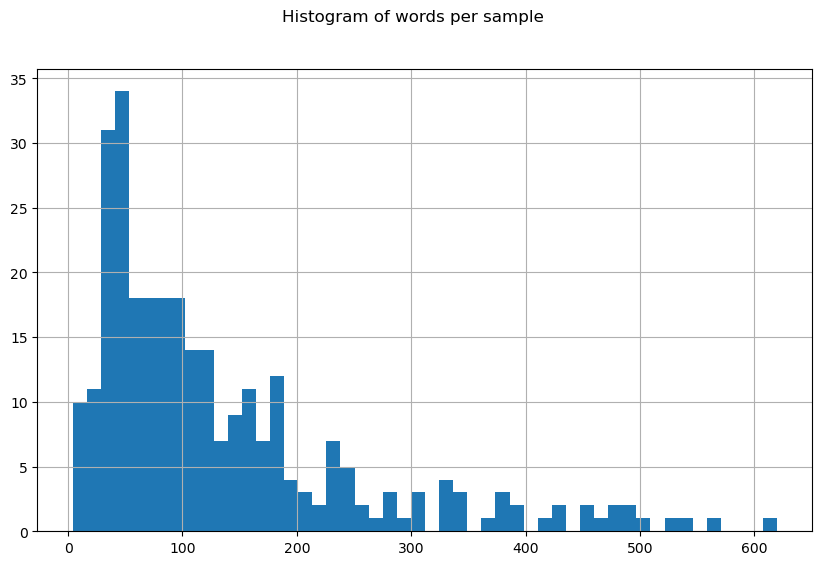

In [11]:
# histogram of words per sample
df_word_list.apply(lambda r: len(r)).hist(bins=50, figsize=(10, 6))
plt.suptitle('Histogram of words per sample')

Text(0.5, 0.98, 'Frequency of the 50 most common words in the dataset')

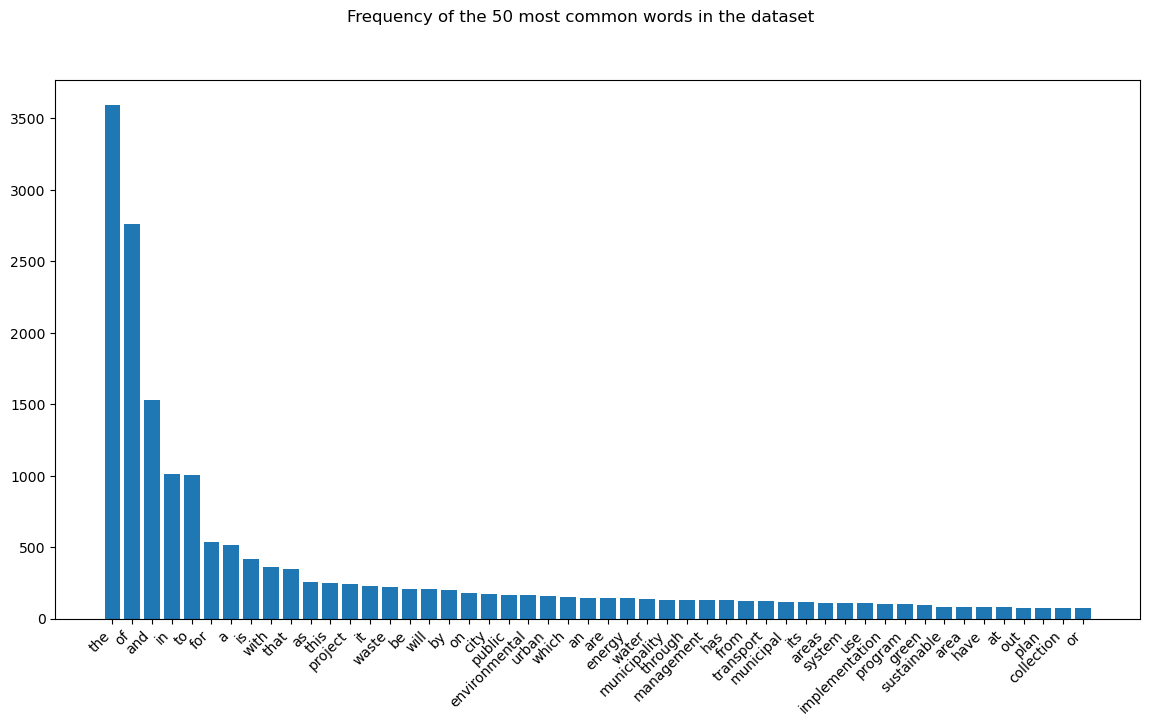

In [12]:
# frequency graph for the most common words
num_words = 50
words = df_word_list.agg('sum')
uniques, unique_counts = np.unique(words, return_counts=True)
sorted_index = np.argsort(unique_counts)[::-1]
plt.figure(figsize=(14, 7))
plt.xticks(rotation=45, ha='right')
plt.bar(uniques[sorted_index][:num_words], unique_counts[sorted_index][:num_words])
plt.suptitle(f'Frequency of the {num_words} most common words in the dataset')

In [12]:

# samples / number of words per sample ratio
# metric suggested by google to determine the approach to solving the problem
# ratio < 1500 suggests tokenizing text as n-grams instead of tokenizing as sequences
# in other words, a small ratio suggests we use simpler approaches to the problem
df_words_per_sample = df_word_list.apply(lambda r: len(r))
ratio = len(df_words_per_sample) / df_words_per_sample.mean()
ratio

2.1830063674563687

In [56]:
# generation of a vocabulary (list of possible tokens) for the manual feature extraction
df_tokens = df_word_list.apply(lambda r: r + [' '.join(t) for t in itertools.pairwise(r)])
token_count = pd.Series(df_tokens.sum()).value_counts()
vocabulary = token_count[token_count > 2].dropna().index.to_list()
len(vocabulary)

4036

In [30]:
# this function implements cross validation for scikit classifiers (that are compatible with scikit-learn's cross_validation_score)
def cross_validate_scikit(df_dataset, 
                          num_folds,
                          input_column,
                          output_column,
                          model_type,
                          num_features):

    t0 = time.time()
    
    # x is input, y is output
    x = df_dataset[input_column].to_numpy()
    y = df_dataset[output_column].to_numpy()
    
    # parameters for the vectorizer
    kwargs = {
        'ngram_range': (1, 2),  # Use 1-grams + 2-grams.
        'dtype': 'int32',
        'strip_accents': 'unicode',
        'decode_error': 'replace',
        'analyzer': 'word',  # Split text into word tokens.
        'min_df': 2,
    }
    vectorizer = TfidfVectorizer(**kwargs)
    x_vec = vectorizer.fit_transform(x)

    # this selects the k best features from the vectorized input
    selector = SelectKBest(f_classif, k=num_features)
    x_kbest = selector.fit_transform(x_vec, y)

    # one hot encodes the output
    label_binarizer = LabelBinarizer()
    y_enc = label_binarizer.fit_transform(y)

    # select Classifier class according to model type
    if model_type == 'mlp':
        model = MLPClassifier(random_state=42, validation_fraction=0.0)
    elif model_type == 'rf':
        model = RandomForestClassifier(random_state=42)
    elif model_type == 'xgb':
        model = XGBClassifier(seed=42)

    # execute cross validation
    cv_score = cross_val_score(model, x_kbest, y_enc, cv=num_folds)
    for k, val_acc in enumerate(cv_score):
        print(f'col: {input_column}, model: {model_type}, features: {num_features}, fold:{k}  val_acc: {val_acc:.4f}')
    print(f'time: {time.time() - t0}\n')

    return cv_score

In [57]:
# function that implements the model creation, training and deletion
def fit_keras(x_train,
              y_train,
              x_val,
              y_val,
              classes,
              model_type,
              hidden_neurons,
              epochs,
              queue):
    
    # tensorflow is imported inside the function because tensorflow is an absolute nightmare with regards to gpu memmory use. doing it like this makes sure the memmory allocated by tensorflow for each model is always deallocated before the next training. otherwise, out of memmory erros occur

    import tensorflow as tf

    from tensorflow.python.util import deprecation
    deprecation._PRINT_DEPRECATION_WARNINGS = False

    import tensorflow_hub as hub

    physical_devices = tf.config.list_physical_devices('GPU')
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

    # bring pre-trained model from tf hub as a layer
    if model_type == 'nnlm128':
        model_link = "https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2"
    elif model_type == 'use':
        model_link = "https://tfhub.dev/google/universal-sentence-encoder/4"
    hub_layer = hub.KerasLayer(model_link, input_shape=[], dtype=tf.string, trainable=True)

    # create the model with the parameters given
    model = tf.keras.Sequential()
    model.add(hub_layer)
    if hidden_neurons > 0:
        model.add(tf.keras.layers.Dropout(0.2))
        model.add(tf.keras.layers.Dense(hidden_neurons, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(len(classes), activation='softmax'))

    # compile the model
    model.compile(optimizer='adam',
                  loss=tf.losses.CategoricalCrossentropy(),
                  metrics=[tf.metrics.CategoricalAccuracy()])

    # finally, fit the model on the data given
    history = model.fit(x_train,
                        y_train,
                        epochs=epochs,
                        batch_size=32,
                        validation_data=[x_val, y_val],
                        verbose=0)

    # return the last validation accuracy
    val_acc = history.history['val_categorical_accuracy'][-1]
    queue.put(val_acc)

In [58]:
# this function implements cross validation for keras classifiers (which are not supported by scikit-learn)
def cross_validate_keras(df_dataset, 
                         num_folds,
                         input_column,
                         output_column,
                         model_type,
                         hidden_neurons,
                         epochs):
    
    t0 = time.time()
    
    # multiprocessing queue for retrieving the fit_keras result
    queue = mp.Queue()
    
    # x is input, y is output
    x = df_dataset[input_column].to_numpy()
    y = df_dataset[output_column].to_numpy()

    # one hot encode the output
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(y)

    # manually create the folds and iterate through them
    cv_score = []
    skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)
    for k, (train, val) in enumerate(skf.split(x, y)):

        # the function is called in another process so that the vram tensorflow allocated can be deallocated after each model is trained
        p = mp.Process(target=fit_keras, args=(x[train],
                                               label_binarizer.transform(y[train]),
                                               x[val],
                                               label_binarizer.transform(y[val]),
                                               np.unique(y),
                                               model_type,
                                               hidden_neurons,
                                               epochs,
                                               queue))
        p.start()
        p.join()

        # retrieve the validation accuracy from the queue
        val_acc = queue.get()
        cv_score.append(val_acc)
        print(f'col: {input_column}, model: {model_type}, neurons: {hidden_neurons}, epochs: {epochs}, fold: {k}, val_acc: {val_acc:.4f}')

    print(f'time: {time.time() - t0}\n')

    return cv_score


In [15]:
# delete results folder if existent
# create new results folder
if os.path.exists('results'):
    shutil.rmtree('results')
os.makedirs('results')

In [ ]:
# these loops implement the grid search to find the best parameters for our solution
queue = mp.Queue()

for input_column in ['title', 'desc', 'title+desc']:

    for model_type in ['nnlm128', 'use', 'mlp', 'rf', 'xgb']:

        if model_type in ['nnlm128', 'use']:

            for hidden_neurons in [0, 32, 64]:

                for epochs in [25, 35]:

                    cv_score = cross_validate_keras(df_dataset=df_clean,
                                                    num_folds=5,
                                                    input_column=input_column,
                                                    output_column='area',
                                                    model_type=model_type,
                                                    hidden_neurons=hidden_neurons,
                                                    epochs=epochs)
                    
                    mean_score = np.mean(cv_score)
                    
                    file_path = os.path.join('results', f'{input_column}_{model_type}_{hidden_neurons}_{epochs}_{mean_score:.4f}')
                    with open(file_path, 'w') as f:
                        f.write(' '.join([f'{score:.4f}' for score in cv_score]))
                    
        elif model_type in ['mlp', 'rf', 'xgb']:

            for num_features in [100, 250, 'all']:

                cv_score = cross_validate_scikit(df_dataset=df_clean,
                                                 num_folds=5,
                                                 input_column=input_column,
                                                 output_column='area',
                                                 model_type=model_type,
                                                 num_features=num_features)
                
                mean_score = np.mean(cv_score)
                    
                file_path = os.path.join('results', f'{input_column}_{model_type}_{num_features}_{mean_score:.4f}')
                with open(file_path, 'w') as f:
                    f.write(' '.join([f'{score:.4f}' for score in cv_score]))

In [59]:
keras_columns = ['input_column', 'model_type', 'hidden_neurons', 'epochs', 'score']
df_results_keras = pd.DataFrame(columns=keras_columns)

scikit_columns = ['input_column', 'model_type', 'num_features', 'score']
df_results_scikit = pd.DataFrame(columns=scikit_columns)

# read the files generated by the grid search and put results on two tables, one for keras and one for scikit-learn
for file_path in sorted(os.listdir('results')):
    info = file_path.split('_')
    info[-1] = float(info[-1])
    if info[1] in ['nnlm128', 'use']:
        df_row = pd.DataFrame(data=[info], columns=keras_columns)
        df_results_keras = pd.concat([df_results_keras, df_row])
    else:
        df_row = pd.DataFrame(data=[info], columns=scikit_columns)
        df_results_scikit = pd.concat([df_results_scikit, df_row])

In [22]:
print(df_results_keras.groupby(['input_column', 'model_type', 'hidden_neurons'])['score'].mean().apply(lambda r: f'{r:.4f}').reset_index().to_markdown(index=False))

| input_column   | model_type   |   hidden_neurons |   score |
|:---------------|:-------------|-----------------:|--------:|
| desc           | nnlm128      |                0 |  0.6597 |
| desc           | nnlm128      |               32 |  0.6633 |
| desc           | nnlm128      |               64 |  0.6702 |
| desc           | use          |                0 |  0.6597 |
| desc           | use          |               32 |  0.6493 |
| desc           | use          |               64 |  0.6545 |
| title          | nnlm128      |                0 |  0.6016 |
| title          | nnlm128      |               32 |  0.6239 |
| title          | nnlm128      |               64 |  0.6342 |
| title          | use          |                0 |  0.6322 |
| title          | use          |               32 |  0.6256 |
| title          | use          |               64 |  0.6271 |
| title+desc     | nnlm128      |                0 |  0.7026 |
| title+desc     | nnlm128      |               32 |  0

In [18]:
print(df_results_keras.groupby(['input_column'])['score'].mean().apply(lambda r: f'{r:.4f}').to_markdown())

| input_column   |   score |
|:---------------|--------:|
| desc           |  0.6595 |
| title          |  0.6241 |
| title+desc     |  0.7064 |


In [27]:
print(df_results_keras.groupby(['model_type'])['score'].mean().apply(lambda r: f'{r:.4f}').to_markdown())

| model_type   |   score |
|:-------------|--------:|
| nnlm128      |  0.6656 |
| use          |  0.6611 |


In [28]:
print(df_results_keras.groupby(['hidden_neurons'])['score'].mean().apply(lambda r: f'{r:.4f}').to_markdown())

|   hidden_neurons |   score |
|-----------------:|--------:|
|                0 |  0.6606 |
|               32 |  0.6615 |
|               64 |  0.6678 |


In [60]:
print(df_results_scikit.groupby(['input_column', 'model_type', 'num_features'])['score'].mean().apply(lambda r: f'{r:.4f}').reset_index().to_markdown(index=False))

| input_column   | model_type   | num_features   |   score |
|:---------------|:-------------|:---------------|--------:|
| desc           | mlp          | 100            |  0.2923 |
| desc           | mlp          | 250            |  0.3992 |
| desc           | mlp          | all            |  0.1855 |
| desc           | rf           | 100            |  0.5157 |
| desc           | rf           | 250            |  0.4744 |
| desc           | rf           | all            |  0.165  |
| desc           | xgb          | 100            |  0.4575 |
| desc           | xgb          | 250            |  0.4848 |
| desc           | xgb          | all            |  0.4302 |
| title          | mlp          | 100            |  0.4022 |
| title          | mlp          | 250            |  0.4403 |
| title          | mlp          | all            |  0.3371 |
| title          | rf           | 100            |  0.4299 |
| title          | rf           | 250            |  0.3542 |
| title          | rf   

In [24]:
print(df_results_scikit.groupby(['input_column'])['score'].mean().apply(lambda r: f'{r:.4f}').to_markdown())

| input_column   |   score |
|:---------------|--------:|
| desc           |  0.3783 |
| title          |  0.3523 |
| title+desc     |  0.4371 |


In [25]:
print(df_results_scikit.groupby(['model_type'])['score'].mean().apply(lambda r: f'{r:.4f}').to_markdown())

| model_type   |   score |
|:-------------|--------:|
| mlp          |  0.3397 |
| rf           |  0.4008 |
| xgb          |  0.4271 |


In [26]:
print(df_results_scikit.groupby(['num_features'])['score'].mean().apply(lambda r: f'{r:.4f}').to_markdown())

| num_features   |   score |
|:---------------|--------:|
| 100            |  0.4336 |
| 250            |  0.4482 |
| all            |  0.2858 |
